## Signal Prediction


# Introduction

**Problem definition:** given 120 historical timestamps with signal classes, predict change in signal for the next 30 steps ahead.

This model is trained for L249, including signals and requests of buses (public transport prioritization).

**Dataset description:**

* Total number of instances: 86400
* Training set: 70%
* Validation set: 20%
* Test set: 10%
* Timestamp - a value representing seconds


Problem settings: predict such tagret virables as **'K01R', 'K02', 'K03'** based on such features as 'timestamp/Uhrzeit' (TX).


*   **BK02**: Bemessung für K02 (Interner Detektor **D21/22**)
*   **ANF_K03**: Anforderung für K03
*   **ZYK**: cycle time

K01R status: R->S->G->A->R (A: Achtung; S: Start; G: Grün; R: Rot), only Green is 1, other status will be set to 0

**Class 1:** green (the vehicle is free to pass the intersection)

**Class 0:** red, yellow, yellow_green (the vehicle must stop)

This notebook consists of the implementation of the following **models**:

* Hybrid model (1basic GCN (A^-1 * X) + 1LSTM)
* activation: Relu (GCN) + tanh (LSTM)


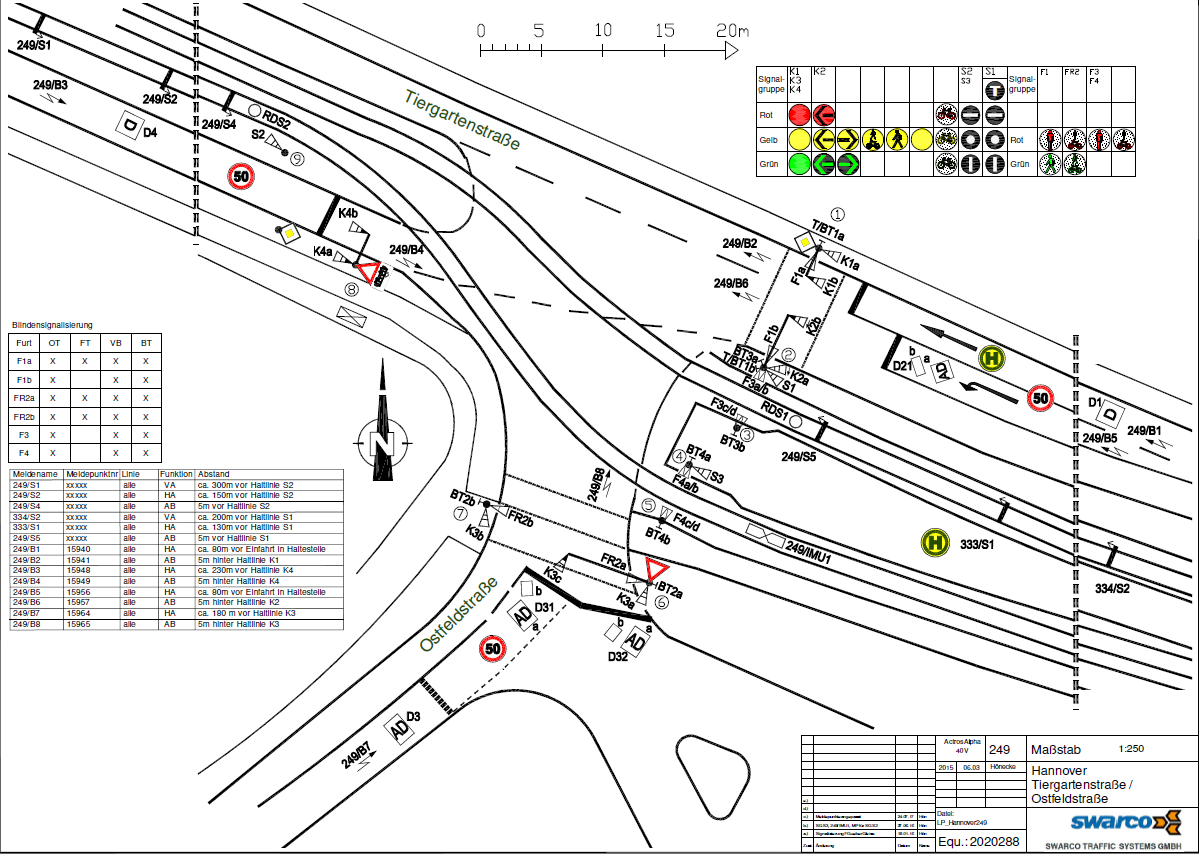

conflict matrix:

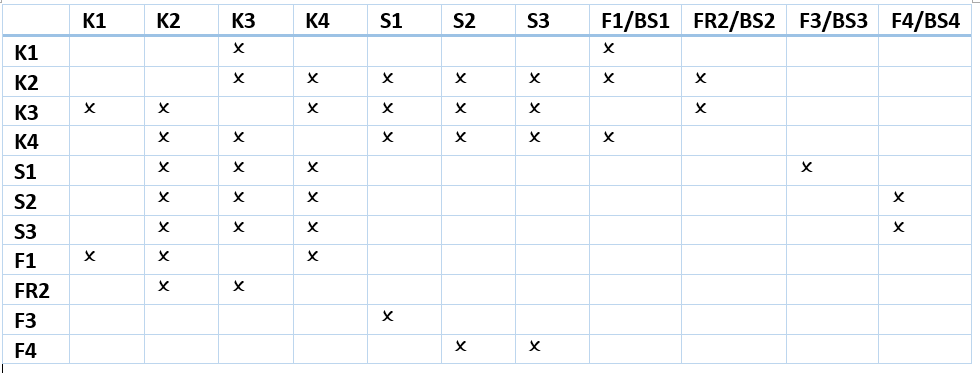

## Adjacency matrix:

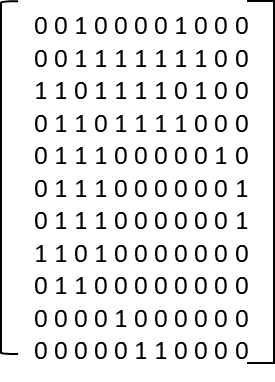

In [ ]:
import networkx as nx
import numpy as np

# using conflict matrix to create an adjacency matrix
adj_matrix = np.array([[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
             [0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
             [1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0],
             [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0],
             [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0],
             [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
             [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
             [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
             [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]])

# Create an undirected graph from adjacency matrix
G = nx.Graph(adj_matrix)
num_nodes=adj_matrix.shape[0]
node_indices, neighbor_indices = np.where(adj_matrix == 1)

# graph info
print("No. of nodes:", num_nodes)
print("Nodes:", G.nodes())
print("Edges:", G.edges())
print("No. of edges:", len(G.edges()))
print("edges[0]: ",node_indices.tolist())
print("edges[1]: ",neighbor_indices.tolist())

No. of nodes: 11
Nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Edges: [(0, 2), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (2, 3), (2, 4), (2, 5), (2, 6), (2, 8), (3, 4), (3, 5), (3, 6), (3, 7), (4, 9), (5, 10), (6, 10)]
No. of edges: 21
edges[0]:  [0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 8, 8, 9, 10, 10]
edges[1]:  [2, 7, 2, 3, 4, 5, 6, 7, 8, 0, 1, 3, 4, 5, 6, 8, 1, 2, 4, 5, 6, 7, 1, 2, 3, 9, 1, 2, 3, 10, 1, 2, 3, 10, 0, 1, 3, 1, 2, 4, 5, 6]


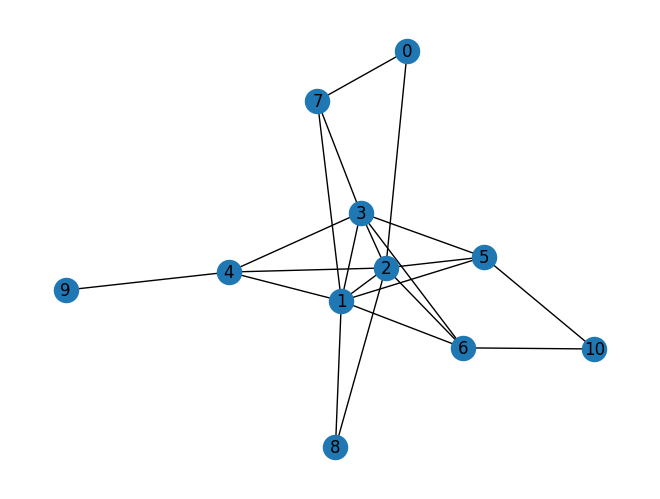

In [ ]:

# Draw graph（Matplotlib library）
nx.draw(G, with_labels=True)

# Data Preparation

In [ ]:
# set a target variable 'K1 (Node0)', 'K2', 'K3', 'K4'
trg = 'K1'
# including Bus

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import requests
import typing
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from tensorflow import feature_column
from tensorflow.keras import layers
import keras.optimizers
mpl.style.use('bmh')

mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False

# for downloading a file from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# loading data from google drive

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/249/2021-12-14-L0249(processed).CSV', low_memory=False)

df=df.drop(columns=['Uhrzeit'])
df

,K1,K2,K3,K4,S1,S1T,S2,S3,F1,FR2,...,MPN_15956,MPN_15957,MPN_15940,MPN_15941,MPN_4,MPN_5,MPN_6,MPN_1,MPN_2,MPN_3
0,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
1,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
2,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
3,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
4,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86396,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86397,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0
86398,G,R,R,G,R,D,R,R,R,G,...,0,0,0,0,0,0,0,0,0,0


## Data Transform

In [ ]:

# add time frame (as index)
df['timestamp'] = df.index
col_name="timestamp"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)

# re-transforming the problem to binary classification
# red, yellow and yellow_red attibutes = 0, green = 1

df.replace('G', '1', inplace=True, regex=True)
df.replace('R', '0', inplace=True, regex=True)
df.replace('A', '0', inplace=True, regex=True)
# acoustic signal for Blinde Lampe
df.replace('a', '1', inplace=True, regex=True)
df.replace('S', '0', inplace=True, regex=True)
df.replace('D', '0', inplace=True, regex=True)

df['AF1'][df.AF1>0]=1
df['AFBT2'][df.AFBT2>0]=1
df['AFBT03'][df.AFBT03>0]=1
df['AFBT01'][df.AFBT01>0]=1
df['AFBT04'][df.AFBT04>0]=1
df['AFK03'][df.AFK03>0]=1
df['AFK02'][df.AFK02>0]=1


df = df.astype(int)

# df = df.rename(columns={' D2': 'D2', ' D3': 'D3', ' D4': 'D4', ' K1': 'K1',' K2':'K2', ' K3':'K3', ' K4':'K4'})
# save a copy of initial df
init_df = df
df

<ipython-input-8-9ea0beec8535>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AF1'][df.AF1>0]=1
<ipython-input-8-9ea0beec8535>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AFBT2'][df.AFBT2>0]=1
<ipython-input-8-9ea0beec8535>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AFBT03'][df.AFBT03>0]=1
<ipython-input-8-9ea0beec8535>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

,timestamp,K1,K2,K3,K4,S1,S1T,S2,S3,F1,...,MPN_15956,MPN_15957,MPN_15940,MPN_15941,MPN_4,MPN_5,MPN_6,MPN_1,MPN_2,MPN_3
0,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,86395,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86396,86396,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86397,86397,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
86398,86398,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Correlation Heatmap

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


<Figure size 800x800 with 0 Axes>

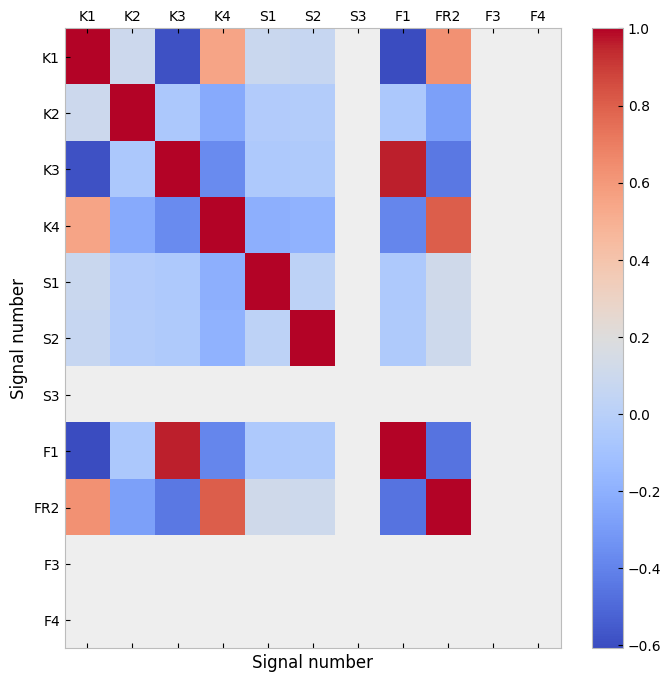

In [ ]:
df_plot = df[['K1','K2','K3','K4','S1','S2','S3','F1','FR2','F3','F4']]
df_plot_array = df_plot.to_numpy()

#draw correlation heatmap of time series of different signals
# Calculate the correlation matrix
corr_matrix = np.corrcoef(df_plot_array.T)

# Handle the case where the standard deviation is zero
stddev = np.std(df_plot_array, axis=0)
stddev_is_zero = stddev == 0
corr_matrix[:, stddev_is_zero] = 0
corr_matrix[stddev_is_zero, :] = 0

# Draw the correlation heatmap
plt.figure(figsize=(8, 8))
#plt.matshow(corr_matrix, 0)
#add colorbar to explain corelation degree
im = plt.matshow(np.corrcoef(df_plot_array.T), cmap='coolwarm', aspect='auto')
plt.colorbar(im)

# Define signal names for the legend
signal_names = df_plot.columns.tolist()

# Add legend with column names
#plt.legend(signal_names, loc='best')

# Customize x and y axis ticks
plt.xticks(range(len(signal_names)), signal_names)  # Set ticks as numbers
plt.yticks(range(len(signal_names)), signal_names)

# Set x-axis tick labels
#plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 45, ha='right')  # Rotate and align x-axis labels

plt.xlabel("Signal number")
plt.ylabel("Signal number")
plt.show()

Divide data:

In [ ]:
# set target variable
#df_k1 = df[['AF1', 'AFBT2', 'AFBT03', 'AFBT01', 'AFBT04', 'AFK03', 'AFK02', 'BK2', 'BK1', 'BK3', 'tan11', 'tan10', 'tan21', 'tan20', 'tanK10', 'tanK40', 'MPN_15948', 'MPN_15949', 'MPN_15940', 'MPN_15941', 'MPN_1', 'MPN_2', 'MPN_3', 'MPN_4', 'MPN_5', 'MPN_6']]
df_k1 = df[['K1','K2','K3','K4','S1','S2','S3','F1','FR2','F3','F4']]
num_columns_k1 = df_k1.shape[1]

num_nodes = num_columns_k1
time_len = df_k1.shape[0]

# trg = 'K1', why to add target in features matrix X??
df_k1['target'] = df[trg]
date_time = pd.to_datetime(df.pop('timestamp'))

df = df_k1

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]


num_features = df.shape[1]
test_df

<ipython-input-10-4240e1a300d3>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k1['target'] = df[trg]


,K1,K2,K3,K4,S1,S2,S3,F1,FR2,F3,F4,target
77760,1,0,0,1,0,0,0,0,1,0,0,1
77761,1,0,0,1,0,0,0,0,1,0,0,1
77762,1,0,0,1,0,0,0,0,1,0,0,1
77763,1,0,0,1,0,0,0,0,1,0,0,1
77764,1,0,0,1,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
86395,1,0,0,1,0,0,0,0,1,0,0,1
86396,1,0,0,1,0,0,0,0,1,0,0,1
86397,1,0,0,1,0,0,0,0,1,0,0,1
86398,1,0,0,1,0,0,0,0,1,0,0,1


In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
K1,86400.0,0.787593,0.409014,0.0,1.0,1.0,1.0,1.0
K2,86400.0,0.035139,0.184132,0.0,0.0,0.0,0.0,1.0
K3,86400.0,0.084317,0.277864,0.0,0.0,0.0,0.0,1.0
K4,86400.0,0.595208,0.490855,0.0,0.0,1.0,1.0,1.0
S1,86400.0,0.027940,0.164801,0.0,0.0,0.0,0.0,1.0
S2,86400.0,0.023762,0.152306,0.0,0.0,0.0,0.0,1.0
S3,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
F1,86400.0,0.090984,0.287588,0.0,0.0,0.0,0.0,1.0
FR2,86400.0,0.680069,0.466452,0.0,0.0,1.0,1.0,1.0
F3,86400.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0


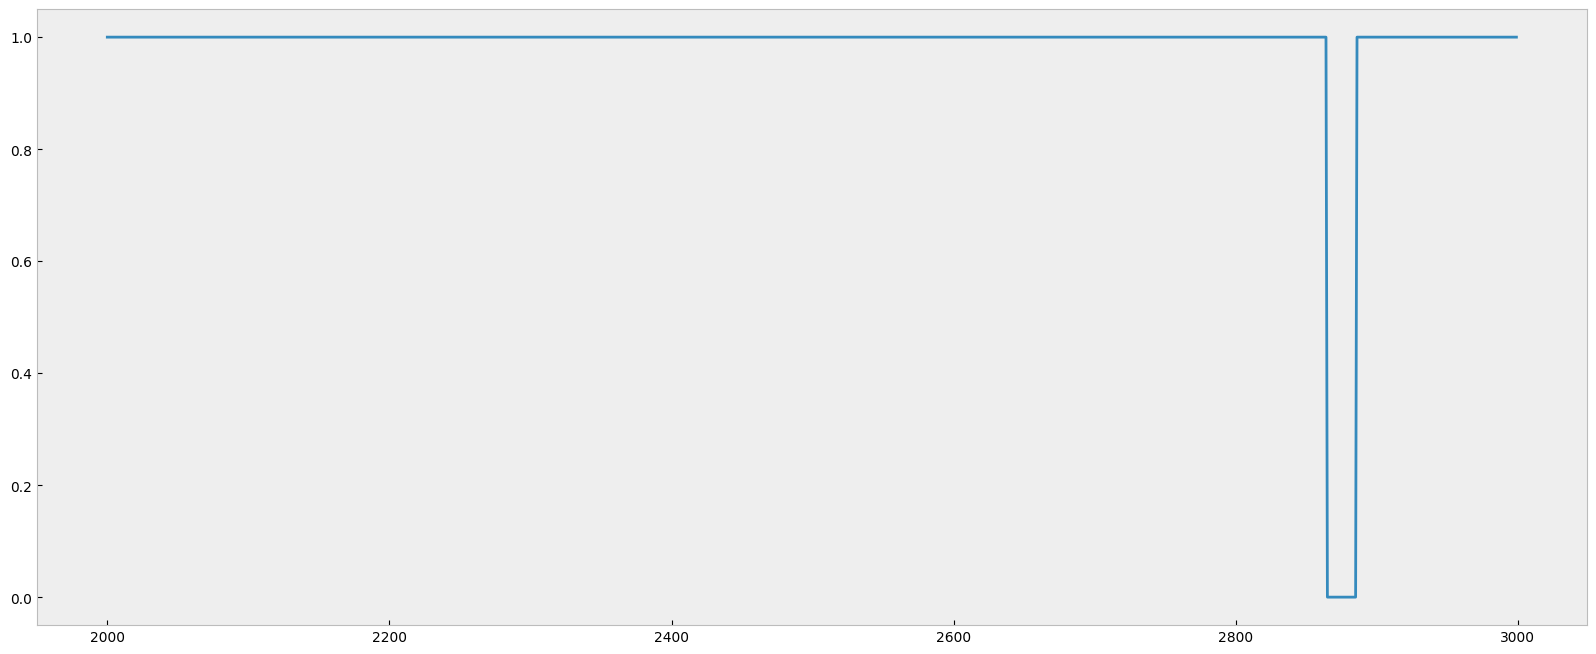

In [ ]:
plt.plot(train_df['target'][2000:3000])

## Time Window Generation

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        #f'Label column name(s): {self.label_columns}'
        ])

In [ ]:
def split_window(self, features):
  batch_size = tf.shape(features)[0]
  # -1 to exclude last features, "targets" here
  inputs = features[:, self.input_slice, :-1]
  # [batch dimension; time dimension; feature columns]
  # label is the last column "target"
  labels = features[:, self.labels_slice, -1:]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Transpose the data
  #inputs = tf.transpose(inputs, perm=[0, 2, 1])
  #labels = tf.transpose(labels, perm=[0, 2, 1])

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  #need:(batch_size, input_seq_len, num_nodes, in_feat) in_feat==1
  inputs.set_shape([None,  self.input_width, None])
  labels.set_shape([None,  self.label_width, 1])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# modified shape for model training, can not be used temporarily
def plot(self, model=None, plot_col='target', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 6))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    marker='o', edgecolors='face', label='Labels', c='#4e8f18', s=84)
        if model is not None:
            # predictions = model.predict(inputs)
            # print(predictions)
            predictions = (model.predict(inputs) > 0.5).astype("int32")
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='*', edgecolors='face', label='Predictions',
                      c='#d1d41c', s=130)

        if n == 0:
            plt.legend()

    plt.xlabel('Time')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
MAX_EPOCHS = 32
# patience = 5
def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy',
                                                    patience=patience,
                                                    mode='max')

  model.compile(optimizer=tf.optimizers.Adam(),
                loss=tf.losses.BinaryCrossentropy(from_logits=True),
                metrics=[tf.metrics.BinaryAccuracy()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
OUT_STEPS = 30
#30
input_width= 120
multi_window = WindowGenerator(input_width=input_width,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot()
multi_window

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

# Machine Learning Training

In [ ]:
multi_val_performance = {}
multi_performance = {}

## GCN LSTM Customlayer

In [ ]:
#!pip install tensorflow --upgrade
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import typing
import tensorflow as tf
import keras
from keras import layers

#from keras import ops

**GCN Layer**

Our implementation of the graph convolution layer is similar to the implementation in this Keras example. Note that in that example, the input to the layer is a 2D tensor with shape `(num_nodes, in_feat)`, whereas in our example, the input to the layer is a 4D tensor with shape `(num_nodes, batch_size, input_seq_length, in_feat)`. The graph convolution layer performs the following steps:

- The node representations are computed by `self.compute_nodes_representation()` by multiplying the input features with `self.weight`.
- The aggregation of neighbors’ messages is computed by `self.compute_aggregated_messages()`, which first aggregates the neighbors’ representations and then multiplies the result by `self.weight`.
- The final output of the layer is computed by `self.update()` by combining the node representations and the aggregated neighbor messages.


In [ ]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        #graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="add",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        #self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = self.add_weight(
            name="weight",
            initializer=keras.initializers.GlorotUniform(),
            shape=(in_feat, out_feat),
            dtype="float32",
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                #self.graph_info.edges[0],
                node_indices.tolist(),
                num_segments=num_nodes, #self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features):
        neighbour_representations = tf.gather(features, neighbor_indices.tolist())#self.graph_info.edges[1]
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation, aggregated_messages):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")
        return self.activation(h)

    def call(self, features):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

**LSTM with Graph Convolution**

By applying the graph convolution layer to the input tensor, we obtain another tensor that contains node representations over time (another 4D tensor). For each time step, the representation of a node is informed by information from its neighbors.

However, to make accurate predictions, we not only need information from neighboring nodes, but also need to process this information over time. To this end, we can pass the tensor of each node to a recurrent layer. The `LSTMGC` layer below first applies a graph convolution layer to the input and then passes the result to an LSTM layer.


In [ ]:
# AR_LSTM layer
class AR_LSTM(layers.Layer):
    def __init__(self, units, out_steps):
        super().__init__()
        self.units = units
        self.out_steps = out_steps
        self.num_features = 10 #out_feat
        self.lstm_cell = layers.LSTMCell(units)
        self.lstm_rnn = layers.RNN(self.lstm_cell, return_state=True)
        self.dense = layers.Dense(self.num_features)

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        return prediction, state

    def call(self, inputs):
        predictions = []
        prediction, state = self.warmup(inputs)
        predictions.append(prediction)
        for n in range(1, self.out_steps):
            x, state = self.lstm_cell(prediction, states=state, training=None)
            prediction = self.dense(x)
            predictions.append(prediction)
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [ ]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        #graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "add",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, **graph_conv_params) #graph_info

        self.arlstm = AR_LSTM(lstm_units, forecast_horizon)
        self.dense = layers.Dense(1) #10->1

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(
            gcn_out, (batch_size * num_nodes, input_seq_len, out_feat)
        )
        lstm_out = self.arlstm(
            gcn_out
        )  #ar lstm_out has shape: (batch_size * num_nodes, output_seq_len, num_features=10)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len) 10->1

        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        output=output[0:1, :, :]#K01
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

**模型训练**

In [ ]:

in_feat = 1 #num_features-1 # exclude "target" in df_k1
batch_size = 32
# epochs = 20
input_sequence_length = 120
forecast_horizon = 30
multi_horizon = True
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "add",
    "activation": "relu",
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    #graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, num_nodes, in_feat))
outputs = st_gcn(inputs)

keras_gcn_lstm_model = keras.models.Model(inputs, outputs)

# train the model and to save
history = compile_and_fit(keras_gcn_lstm_model, multi_window)

Epoch 1/32
1886/1886 [==============================] - 921s 483ms/step - loss: 0.4181 - binary_accuracy: 0.8192 - val_loss: 0.4572 - val_binary_accuracy: 0.7996
Epoch 2/32
1886/1886 [==============================] - 901s 478ms/step - loss: 0.3474 - binary_accuracy: 0.8359 - val_loss: 0.4833 - val_binary_accuracy: 0.7941
Epoch 3/32
1886/1886 [==============================] - 896s 475ms/step - loss: 0.4278 - binary_accuracy: 0.8168 - val_loss: 0.4524 - val_binary_accuracy: 0.7368
Epoch 4/32
1886/1886 [==============================] - 920s 488ms/step - loss: 0.3233 - binary_accuracy: 0.8353 - val_loss: 0.4387 - val_binary_accuracy: 0.8141
Epoch 5/32
1886/1886 [==============================] - 902s 478ms/step - loss: 0.3461 - binary_accuracy: 0.8365 - val_loss: 0.4613 - val_binary_accuracy: 0.8048
Epoch 6/32
1886/1886 [==============================] - 859s 455ms/step - loss: 0.3280 - binary_accuracy: 0.8335 - val_loss: 0.4456 - val_binary_accuracy: 0.8132
Epoch 7/32
1886/1886 [======

In [ ]:
# after training, save the model
keras_gcn_lstm_model.save('/content/drive/MyDrive/Colab Notebooks/249/models/keras_gcn_arlstm_model_1Day_targetout')
IPython.display.clear_output()

multi_val_performance['GCN_LSTM_Keras'] = keras_gcn_lstm_model.evaluate(multi_window.val)
multi_performance['GCN_LSTM_Keras'] = keras_gcn_lstm_model.evaluate(multi_window.test, verbose=0)

536/536 [==============================] - 95s 177ms/step - loss: 0.4386 - binary_accuracy: 0.8138


In [ ]:
keras_gcn_lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 11, 1)]      0         
                                                                 
 lstmgc (LSTMGC)             (None, 30, 1)             19871     
                                                                 
Total params: 19871 (77.62 KB)
Trainable params: 19871 (77.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Performance


### Binary Accuracy

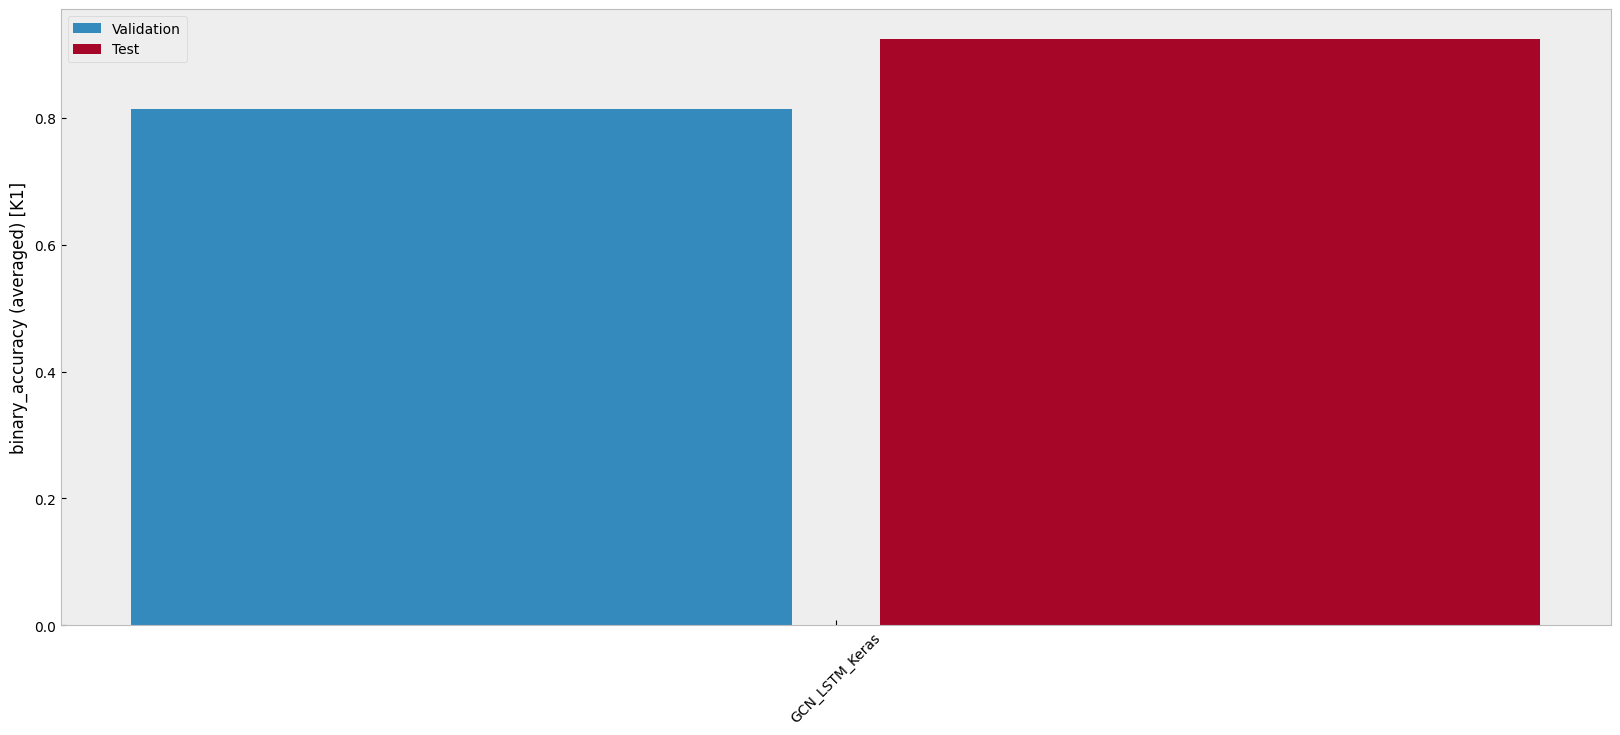

In [ ]:
# performance

x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'binary_accuracy'
metric_index = keras_gcn_lstm_model.metrics_names.index('binary_accuracy')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'binary_accuracy (averaged) ' + '['+ trg + ']')
_ = plt.legend()

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

GCN_LSTM_Keras: 0.9247


In [ ]:
print(multi_performance)

{'GCN_LSTM_Keras': [0.2780400812625885, 0.92466139793396]}


In [ ]:
for name, value in multi_val_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

GCN_LSTM_Keras: 0.8138


### Basic Metrics
All trained models have been saved and do not require repeated training runs; they can be loaded directly. This section and the training section code can be run separately.

#### seq-2-step evaluation

In [ ]:
OUT_STEPS_1 = 1
input_width_1= 120
multi_window_1 = WindowGenerator(input_width=input_width_1,
                               label_width=OUT_STEPS_1,
                               shift=OUT_STEPS_1)

multi_window_1

Total window size: 121
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120]

In [ ]:
print(test_df.shape)

# obtain an element
sample_element = next(iter(multi_window_1.test))

# print shapes
print("Shape of the sample element:", sample_element[0].shape)  # shape of input
print("Shape of the labels:", sample_element[1].shape)  # shape of label

print(len(list(iter(sample_element[0]))))

(8640, 12)
Shape of the sample element: (32, 120, 11)
Shape of the labels: (32, 1, 1)
32


In [ ]:
check_it = iter(multi_window_1.test)
check_list=list(check_it)
check_features, check_labels = check_list[0]
print('iteration length:',len(check_list))
#print(check_list[0])
print('fist inputs size',check_features.shape)
print('fist labels size',check_labels.shape)
test_dataset_length = tf.data.experimental.cardinality(multi_window_1.test).numpy()
print("Test dataset length:", test_dataset_length)
print(check_features.shape[0])

iteration length: 267
fist inputs size (32, 120, 11)
fist labels size (32, 1, 1)
Test dataset length: 267
32


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

# load models
keras_gcn_lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/keras_gcn_arlstm_model_1Day_targetout')

# initiation
y_tests = []

predictions_gcn_lstm = []
y_probas_gcn_lstm =[]

i = 0
it = iter(multi_window_1.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(267): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result

        # GCN-LSTM-proba (float probability)
        y_proba_gcn_lstm = keras_gcn_lstm_model.predict(inputs)
        y_proba_gcn_lstm_reshape = tf.transpose(y_proba_gcn_lstm, [0,2,1])
        # GCN-LSTM-predictions (binary int)
        prediction_gcn_lstm = tf.cast(y_proba_gcn_lstm_reshape > 0.5, tf.int32)
        #reshape (32,1,11)->(32,11,1) num_nodes=11,batchsize=32
        labels_reshape = tf.transpose(labels, [0, 2, 1])
        #prediction_gcn_lstm_reshape = tf.transpose(prediction_gcn_lstm, [0,2,1])

        # M: batch size
        M = inputs.shape[0]
        #print(inputs.shape)
        #print(labels.shape)
        for j in range(M):
          #batchsize 32,
          y_test = labels_reshape[j, multi_window_1.column_indices['K1']]
          y_tests.extend(y_test)
          #用预测值更新inputs 调用predict() 共30次作为seq output.
          # -6- GCN-LSTM
          # each time outputs one value
          predictions_gcn_lstm.append(prediction_gcn_lstm[j, multi_window_1.column_indices['K1'],0])
          y_probas_gcn_lstm.append(y_proba_gcn_lstm_reshape[j, multi_window_1.column_indices['K1'],0])




# -6- GCN-LSTM
acc_gcn_lstm = metrics.accuracy_score(y_tests, predictions_gcn_lstm)
ppv_gcn_lstm = metrics.precision_score(y_tests, predictions_gcn_lstm)
tpr_gcn_lstm = metrics.recall_score(y_tests, predictions_gcn_lstm)
f1_gcn_lstm = metrics.f1_score(y_tests, predictions_gcn_lstm)
mcc_gcn_lstm = metrics.matthews_corrcoef(y_tests, predictions_gcn_lstm)
conf_gcn_lstm = metrics.confusion_matrix(y_tests, predictions_gcn_lstm)



print("-6- GCN-LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm: .3f}")
print(f"F1 score:                   {f1_gcn_lstm: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm: .3f}")
print("confusion matrix: ", conf_gcn_lstm)


1/1 [==============================] - 1s 556ms/step
-6- GCN-LSTM Model
Accuracy (ACC):                 0.992
Precision score (PPV):             0.995
Recall score (TPR):              0.997
F1 score:                    0.996
Matthew's correlation coefficient (MCC):   0.960
confusion matrix:  [[ 864   41]
 [  24 7591]]


##### ROC AUC Curve

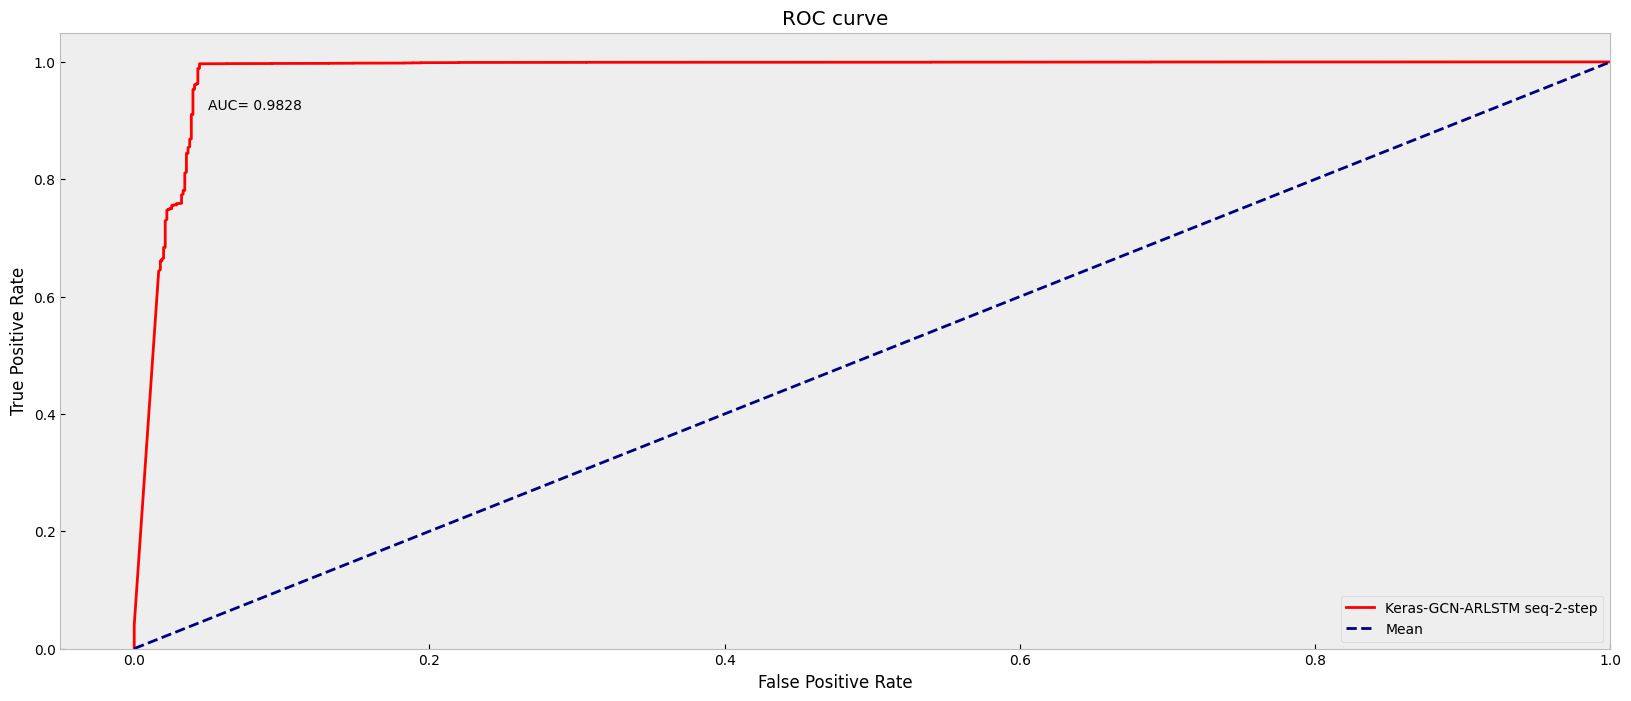

In [ ]:

FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, _ = roc_curve(y_tests, y_probas_gcn_lstm)

# ROC-AUC
auc_score_gcn_lstm_step = metrics.roc_auc_score(y_tests, y_probas_gcn_lstm)

# Plot the ROC curve
plt.plot(FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, color='red', lw=2, label='Keras-GCN-ARLSTM seq-2-step')
plt.annotate(f'AUC={auc_score_gcn_lstm_step: .4f}', xy=(0.05,0.92) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

#### seq-2-seq 30s evaluation

只为 Basic Metrics 创建 multi_window_forTEST, recurrent calculate seq-2-point to output 30s as a seq-2-seq.

In [ ]:
OUT_STEPS_TEST = 30
input_width_TEST= 120
multi_window_forTEST = WindowGenerator(input_width=input_width_TEST,
                               label_width=OUT_STEPS_TEST,
                               shift=OUT_STEPS_TEST)

#multi_window.plot()
multi_window_forTEST

Total window size: 150
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149]

In [ ]:
print('iter: ', len(list(multi_window_forTEST.test)))

iter:  266


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

# load models
keras_gcn_lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/keras_gcn_arlstm_model_1Day_targetout')

# initiation
y_tests_30 = []

predictions_gcn_lstm_30 = []
y_probas_gcn_lstm_30 =[]

i = 0
it = iter(multi_window_forTEST.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result

        # GCN-LSTM-proba (float probability)
        y_proba_gcn_lstm_30 = keras_gcn_lstm_model.predict(inputs)
        #y_proba_gcn_lstm_30_reshape = tf.transpose(y_proba_gcn_lstm_30, [0,2,1])
        # GCN-LSTM-predictions (binary int)
        prediction_gcn_lstm_30 = tf.cast(keras_gcn_lstm_model.predict(inputs) > 0.5, tf.int32)
        #reshape (32,1,11)->(32,11,1) num_nodes=11,batchsize=32
        #labels_30_reshape = tf.transpose(labels, [0, 2, 1])
        #prediction_gcn_lstm_reshape = tf.transpose(prediction_gcn_lstm, [0,2,1])

        # M: batch size
        #M = inputs.shape[0]
        #print(inputs.shape)
        #print(labels.shape)
        #for j in range(M):
          #batchsize 32,
        y_test = labels[0, :, multi_window_forTEST.column_indices['K1']]
        y_tests_30.extend(y_test)
        #用预测值更新inputs 调用predict() 共30次作为seq output.
        # -6- GCN-LSTM
        # each time outputs one value
        predictions_gcn_lstm_30.extend(prediction_gcn_lstm_30[0, :, multi_window_forTEST.column_indices['K1']])
        y_probas_gcn_lstm_30.extend(y_proba_gcn_lstm_30[0, :, multi_window_forTEST.column_indices['K1']])


# -6- GCN-LSTM
acc_gcn_lstm_30 = metrics.accuracy_score(y_tests_30, predictions_gcn_lstm_30)
ppv_gcn_lstm_30 = metrics.precision_score(y_tests_30, predictions_gcn_lstm_30)
tpr_gcn_lstm_30 = metrics.recall_score(y_tests_30, predictions_gcn_lstm_30)
f1_gcn_lstm_30 = metrics.f1_score(y_tests_30, predictions_gcn_lstm_30)
mcc_gcn_lstm_30 = metrics.matthews_corrcoef(y_tests_30, predictions_gcn_lstm_30)
conf_gcn_lstm_30 = metrics.confusion_matrix(y_tests_30, predictions_gcn_lstm_30)



print("-6- GCN-LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm_30: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm_30: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm_30: .3f}")
print(f"F1 score:                   {f1_gcn_lstm_30: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm_30: .3f}")
print("confusion matrix: ", conf_gcn_lstm_30)


1/1 [==============================] - 0s 184ms/step
-6- GCN-LSTM Model
Accuracy (ACC):                 0.933
Precision score (PPV):             0.935
Recall score (TPR):              0.996
F1 score:                    0.964
Matthew's correlation coefficient (MCC):   0.470
confusion matrix:  [[ 198  507]
 [  31 7244]]


In [ ]:
print(y_proba_gcn_lstm.shape)
print(prediction_gcn_lstm.shape)
print('inputs_shape:', inputs.shape)
print('labels_shape:', labels.shape)
print('y_tests length:', len(y_tests))
print('y probas length:', len(y_probas_gcn_lstm))

(8, 30, 1)
(8, 1, 30)
inputs_shape: (11, 120, 11)
labels_shape: (11, 30, 1)
y_tests length: 8520
y probas length: 8520


##### ROC AUC Curve


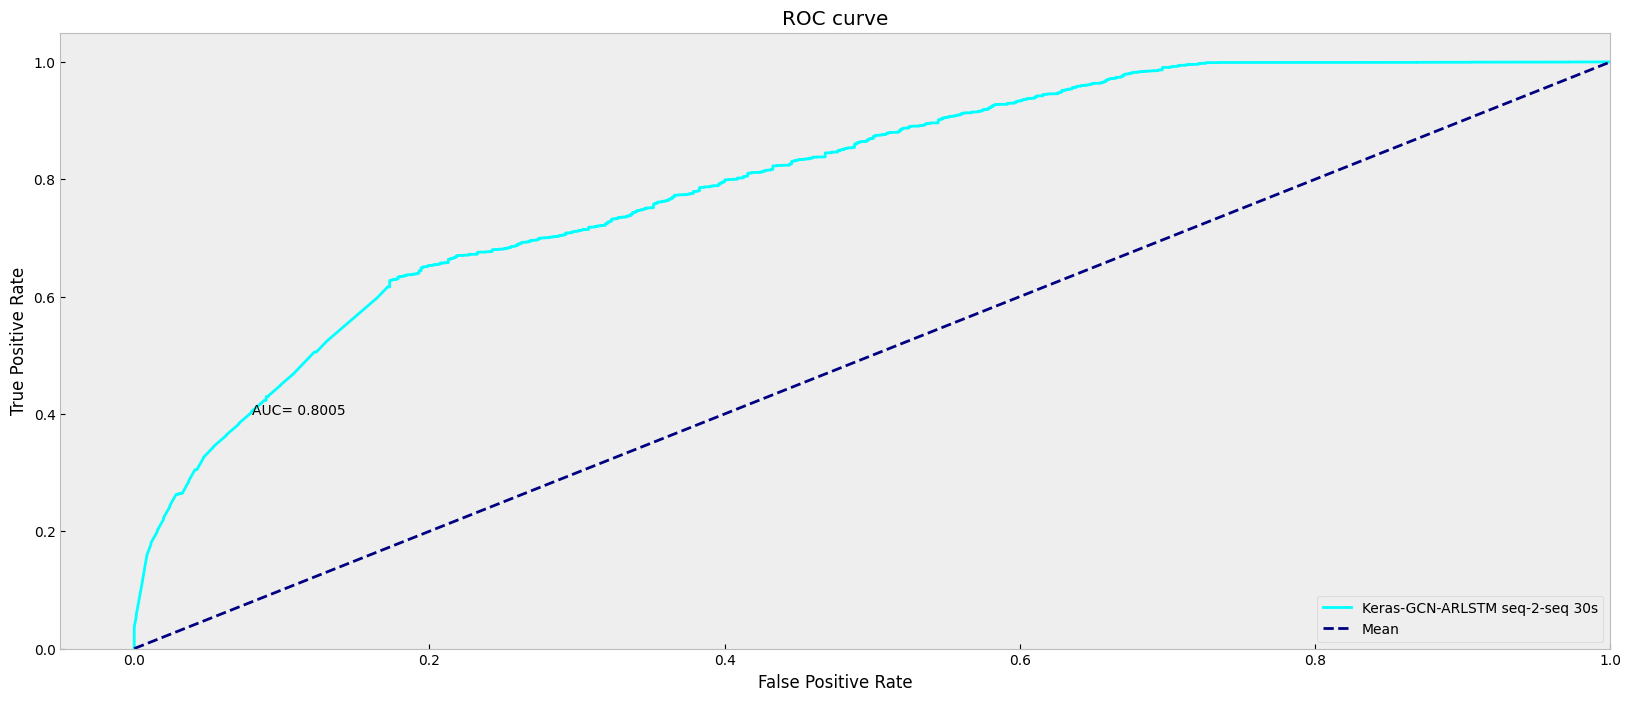

In [ ]:

FPRs_gcn_lstm_seq, TPRs_gcn_lstm_seq, _ = roc_curve(y_tests_30, y_probas_gcn_lstm_30)

# ROC-AUC

auc_score_gcn_lstm_seq = metrics.roc_auc_score(y_tests_30, y_probas_gcn_lstm_30)

# Plot the ROC curve

plt.plot(FPRs_gcn_lstm_seq, TPRs_gcn_lstm_seq, color='cyan', lw=2, label='Keras-GCN-ARLSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq: .4f}', xy=(0.08,0.4) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

####seq-2-seq 15s evaluation
Create multi_window_forTEST for Basic Metrics , recurrent calculate seq-2-step to output 15s as a seq-2-seq.

In [ ]:
OUT_STEPS_15 = 15
input_width_15= 120
multi_window_15 = WindowGenerator(input_width=input_width_15,
                               label_width=OUT_STEPS_15,
                               shift=OUT_STEPS_15)

multi_window_15

Total window size: 135
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119]
Label indices: [120 121 122 123 124 125 126 127 128 129 130 131 132 133 134]

In [ ]:
print('iter: ', len(list(multi_window_15.test)))

iter:  266


In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.utils.multiclass import type_of_target
from sklearn import metrics

# load models
keras_gcn_lstm_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/249/models/keras_gcn_arlstm_model_1Day_targetout')

# initiation
y_tests_15 = []

predictions_gcn_lstm_15 = []
y_probas_gcn_lstm_15 =[]

i = 0
it = iter(multi_window_15.test)

# 280*30+120 = 8520 < 8640 (length of test set)

for i in range(266): #266
        # 获得下一个值:
        result = next(it)
        inputs, labels = result

        # GCN-LSTM-proba (float probability)
        y_proba_gcn_lstm_15 = keras_gcn_lstm_model.predict(inputs)

        # GCN-LSTM-predictions (binary int)
        prediction_gcn_lstm_15 = tf.cast(keras_gcn_lstm_model.predict(inputs) > 0.5, tf.int32)

        #for j in range(M):
          #batchsize 32,
        y_test = labels[0, :15, multi_window_forTEST.column_indices['K1']]
        y_tests_15.extend(y_test)
        #用预测值更新inputs 调用predict() 共30次作为seq output.
        # -6- GCN-LSTM
        # each time outputs one value
        predictions_gcn_lstm_15.extend(prediction_gcn_lstm_15[0, :15, multi_window_forTEST.column_indices['K1']])
        y_probas_gcn_lstm_15.extend(y_proba_gcn_lstm_15[0, :15, multi_window_forTEST.column_indices['K1']])

        y_test_1 = labels[1, :15, multi_window_forTEST.column_indices['K1']]
        y_tests_15.extend(y_test_1)
        predictions_gcn_lstm_15.extend(prediction_gcn_lstm_15[1, :15, multi_window_forTEST.column_indices['K1']])
        y_probas_gcn_lstm_15.extend(y_proba_gcn_lstm_15[1, :15, multi_window_forTEST.column_indices['K1']])


# -6- GCN-LSTM
acc_gcn_lstm_15 = metrics.accuracy_score(y_tests_15, predictions_gcn_lstm_15)
ppv_gcn_lstm_15 = metrics.precision_score(y_tests_15, predictions_gcn_lstm_15)
tpr_gcn_lstm_15 = metrics.recall_score(y_tests_15, predictions_gcn_lstm_15)
f1_gcn_lstm_15 = metrics.f1_score(y_tests_15, predictions_gcn_lstm_15)
mcc_gcn_lstm_15 = metrics.matthews_corrcoef(y_tests_15, predictions_gcn_lstm_15)
conf_gcn_lstm_15 = metrics.confusion_matrix(y_tests_15, predictions_gcn_lstm_15)



print("-6- GCN-LSTM Model")
print(f"Accuracy (ACC):                {acc_gcn_lstm_15: .3f}")
print(f"Precision score (PPV):            {ppv_gcn_lstm_15: .3f}")
print(f"Recall score (TPR):             {tpr_gcn_lstm_15: .3f}")
print(f"F1 score:                   {f1_gcn_lstm_15: .3f}")
print(f"Matthew's correlation coefficient (MCC):  {mcc_gcn_lstm_15: .3f}")
print("confusion matrix: ", conf_gcn_lstm_15)


1/1 [==============================] - 0s 144ms/step
-6- GCN-LSTM Model
Accuracy (ACC):                 0.958
Precision score (PPV):             0.963
Recall score (TPR):              0.991
F1 score:                    0.977
Matthew's correlation coefficient (MCC):   0.786
confusion matrix:  [[ 670  268]
 [  64 6978]]


#####ROC AUC Curve

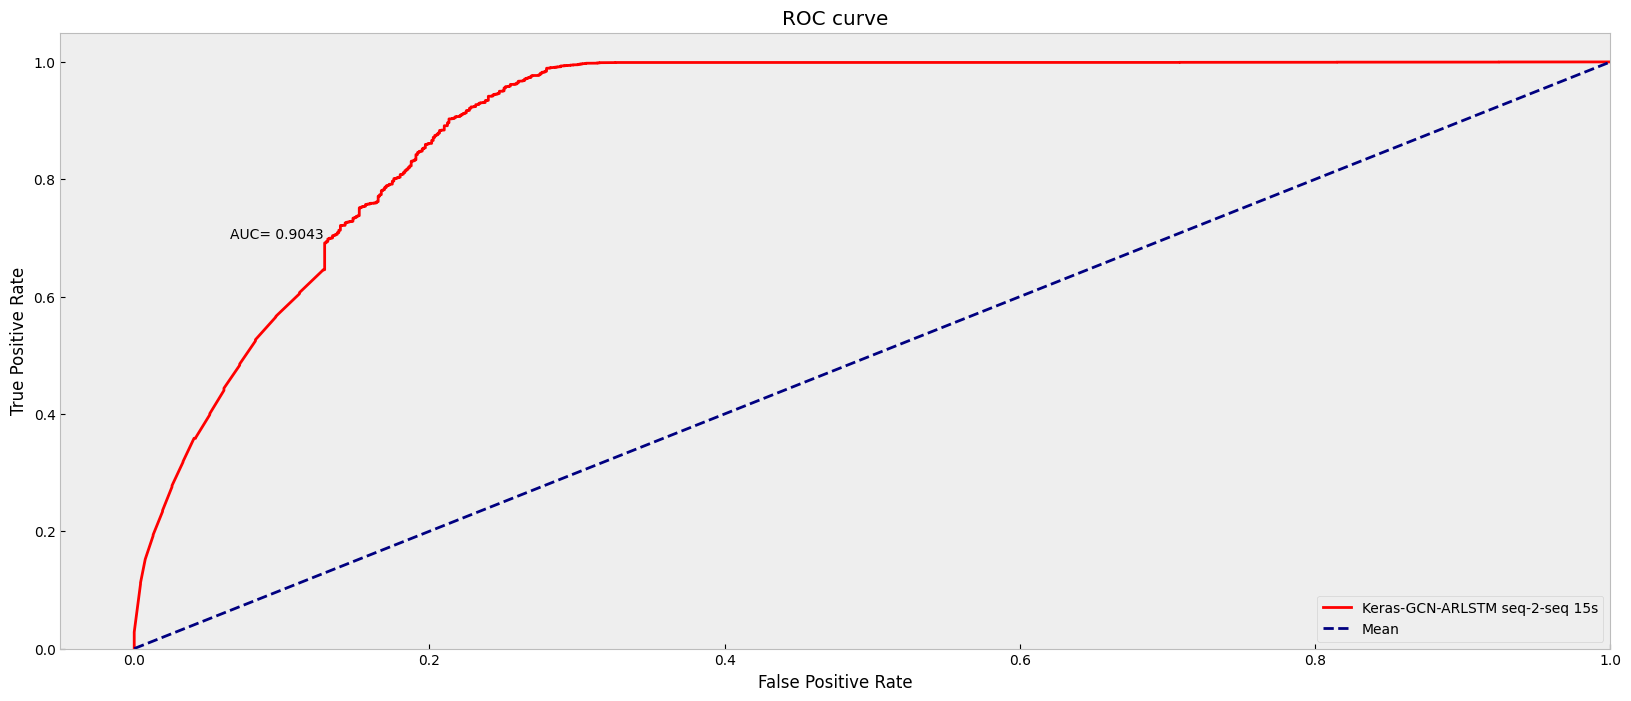

In [ ]:

FPRs_gcn_lstm_seq_15, TPRs_gcn_lstm_seq_15, _ = roc_curve(y_tests_15, y_probas_gcn_lstm_15)

# ROC-AUC
auc_score_gcn_lstm_seq_15 = metrics.roc_auc_score(y_tests_15, y_probas_gcn_lstm_15)

# Plot the ROC curve
plt.plot(FPRs_gcn_lstm_seq_15, TPRs_gcn_lstm_seq_15, color='red', lw=2, label='Keras-GCN-ARLSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq_15: .4f}', xy=(0.065,0.7) )
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
print('connecting')

connecting


#### ROC AUC Curve comparison

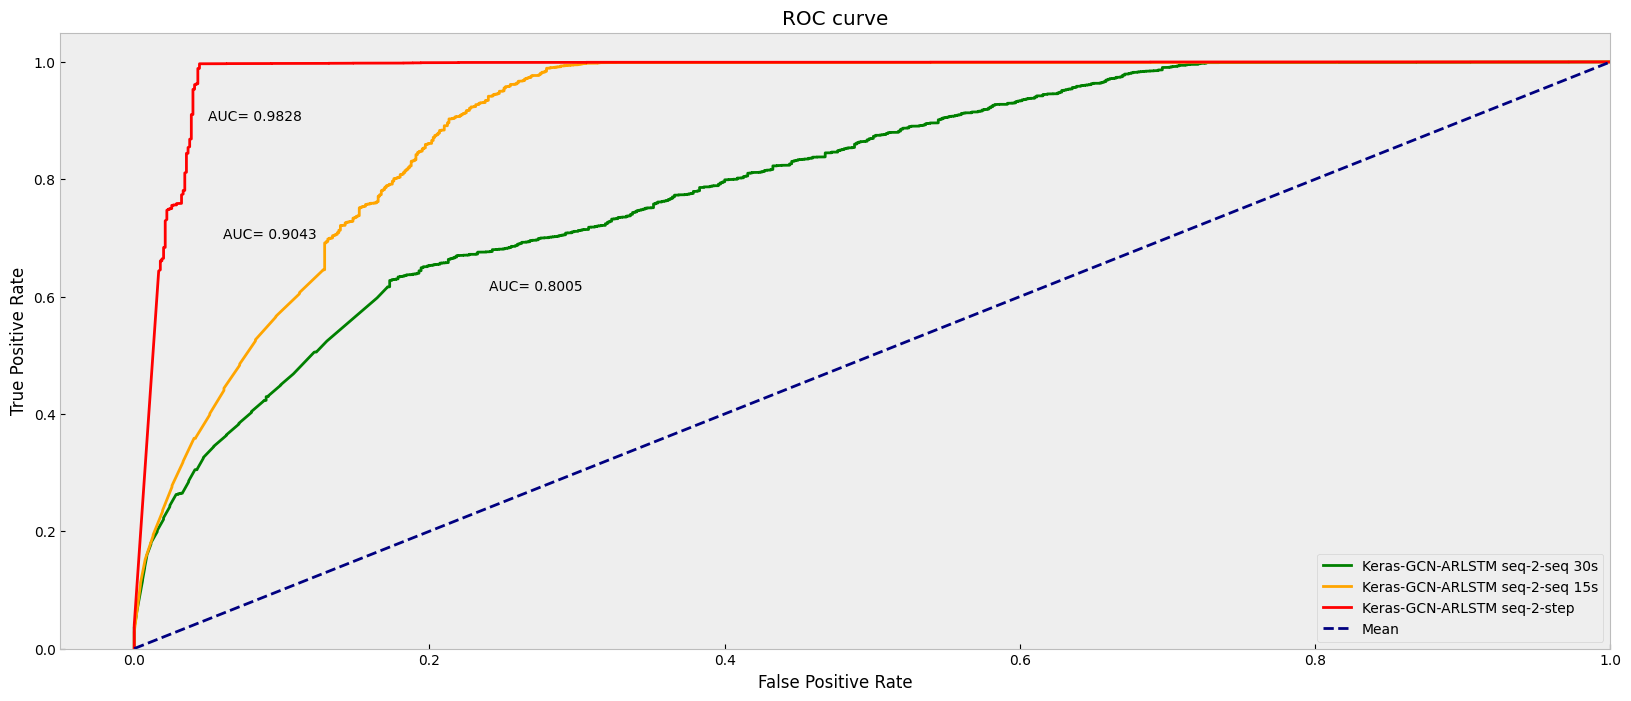

In [ ]:
#FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, _ = roc_curve(y_tests, y_probas_gcn_lstm)
#FPRs_gcn_lstm, TPRs_gcn_lstm, _ = roc_curve(y_tests, y_probas_gcn_lstm)

# ROC-AUC
#auc_score_gcn_lstm_step = metrics.roc_auc_score(y_tests, y_probas_gcn_lstm)
#auc_score_gcn_lstm = metrics.roc_auc_score(y_tests, y_probas_gcn_lstm)

# Plot the ROC curve
plt.plot(FPRs_gcn_lstm_seq, TPRs_gcn_lstm_seq, color='green', lw=2, label='Keras-GCN-ARLSTM seq-2-seq 30s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq: .4f}', xy=(0.24,0.61) )

plt.plot(FPRs_gcn_lstm_seq_15, TPRs_gcn_lstm_seq_15, color='orange', lw=2, label='Keras-GCN-ARLSTM seq-2-seq 15s')
plt.annotate(f'AUC={auc_score_gcn_lstm_seq_15: .4f}', xy=(0.06,0.7) )

plt.plot(FPRs_gcn_lstm_step, TPRs_gcn_lstm_step, color='red', lw=2, label='Keras-GCN-ARLSTM seq-2-step')
plt.annotate(f'AUC={auc_score_gcn_lstm_step: .4f}', xy=(0.05,0.9) )

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Mean")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()